**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets, feature_extraction
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric, NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [52]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            arr = np.array(X)
            self.train_y = np.array(y)
            self.tree = KDTree(arr, metric=self.metric)
        elif self.algorithm == 'brute':
            self.train_x = np.array(X)
            self.train_y = np.array(y)
            self.neigh = NearestNeighbors(self.n_neighbors, metric=self.metric)
            self.neigh.fit(X)
        self.number_of_classes = len(np.unique(self.train_y))

    def predict_brute(self, X):
        test_labels = []
        ind = self.neigh.kneighbors(X, return_distance=False)
        for y in self.train_y[ind]:
            test_labels = np.append(test_labels, np.bincount(y).argmax())
        return test_labels.astype(int)

    def predict_proba_brute(self, X):
        test_labels = np.array([])
        dist, ind = self.neigh.kneighbors(X)
        for y in self.train_y[ind]:
            stat = np.array([])
            for i in range(self.number_of_classes):
                stat = np.append(stat, np.count_nonzero(y == i))
            test_labels = np.append(test_labels, stat)
        test_labels.shape = (X.shape[0], self.number_of_classes)
        test_labels = np.divide(test_labels, self.n_neighbors)
        return test_labels

    def predict_kd_tree(self, X):
        test_labels = np.array([])
        dist, ind = self.tree.query(X, k=self.n_neighbors)
        for y in self.train_y[ind]:
            test_labels = np.append(test_labels, np.bincount(y).argmax())
        return test_labels.astype(int)

    def predict_proba_kd_tree(self, X):
        test_labels = np.array([])
        dist, ind = self.tree.query(X, k=self.n_neighbors)
        for y in self.train_y[ind]:
            stat = np.array([])
            for i in range(self.number_of_classes):
                stat = np.append(stat, np.count_nonzero(y == i))
            test_labels = np.append(test_labels, stat)
        test_labels.shape = (X.shape[0], self.number_of_classes)
        test_labels = np.divide(test_labels, self.n_neighbors)
        return test_labels

    def predict(self, X):
        if self.algorithm == 'brute':
            return np.array(self.predict_brute(X))
        elif self.algorithm == 'kd_tree':
            return np.array(self.predict_kd_tree(X))

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            return self.predict_proba_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_proba_kd_tree(X, )

    def score(self, X, y):
        vector = np.subtract(self.predict(X), y)
        summa = np.count_nonzero(vector)
        return 1 - summa/y.shape[0]
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)


In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

In [8]:
print(clf.score(X_test,y_test))
print(my_clf.score(X_test,y_test))

1.0
1.0


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 572 µs, sys: 120 µs, total: 692 µs
Wall time: 589 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 800 µs, sys: 530 µs, total: 1.33 ms
Wall time: 1.13 ms


In [11]:
%time clf.predict(X_test)

CPU times: user 2.13 ms, sys: 344 µs, total: 2.48 ms
Wall time: 3.4 ms


array([2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 0])

In [12]:
%time  my_clf.predict(X_test)

CPU times: user 1.02 ms, sys: 166 µs, total: 1.19 ms
Wall time: 1.09 ms


array([2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 0])

In [13]:
%time clf.predict_proba(X_test)

CPU times: user 955 µs, sys: 504 µs, total: 1.46 ms
Wall time: 964 µs


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [14]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.24 ms, sys: 693 µs, total: 2.93 ms
Wall time: 2.33 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [15]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
%time clf.fit(X_train, y_train)

CPU times: user 831 µs, sys: 127 µs, total: 958 µs
Wall time: 868 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [18]:
%time my_clf.fit(X_train, y_train)

CPU times: user 211 µs, sys: 59 µs, total: 270 µs
Wall time: 223 µs


In [19]:
%time clf.predict(X_test)

CPU times: user 1.47 ms, sys: 95 µs, total: 1.57 ms
Wall time: 1.57 ms


array([1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1])

In [20]:
%time my_clf.predict(X_test)

CPU times: user 829 µs, sys: 573 µs, total: 1.4 ms
Wall time: 985 µs


array([1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1])

In [21]:
%time clf.predict_proba(X_test)

CPU times: user 1.02 ms, sys: 170 µs, total: 1.19 ms
Wall time: 1.17 ms


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [22]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.86 ms, sys: 1.06 ms, total: 2.92 ms
Wall time: 2.85 ms


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [23]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [24]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [25]:
data = newsgroups['data']
target = newsgroups['target']


Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [26]:
import string
import re
symbs = string.ascii_lowercase+string.digits
data = list(map(lambda x: x.lower(), data))

reg = re.compile('[^a-z ]')
for i, text in enumerate(data):
    text = text.replace('\n', ' ').replace('\t', ' ')
    data[i] = reg.sub('', text)
data_tok = list(map(lambda x: list(x.split(' ')), data))     

In [27]:
inds = np.where(True == np.array(list(((map(lambda tok: all(map(lambda x: x=='', tok)), data_tok))))))

In [28]:
data_tok = np.delete(data_tok, inds)
target = np.delete(target, inds)

In [29]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j) означает, что в документе i слово j встретилось x раз

Для начала произведем лемматизацию текстов для сокращения количества признаков. После получения разреженной матрицы избавимся от шумовых признаков: мусора и слов, встречающихся сликшом часто. Это могут быть предлоги, союзы, местоимения и проч., которые лишь зашумляют и "захламляют" данные

In [9]:
!pip install nltk

In [30]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
lem_data_tok = [[lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)] for text in data]


[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
from scipy.sparse import csr_matrix
data = []
indptr = [0]
indices = []
vocabulary = {}

for l in lem_data_tok:
    for term in l:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))


data_tok_vect = csr_matrix((data, indices, indptr), dtype=int).toarray()

In [32]:
data_tok_vect = np.delete(data_tok_vect, inds, axis = 0)


In [33]:
sums = data_tok_vect.sum(axis = 0)


In [34]:
data_tok_vect

array([[3, 4, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [8, 2, 1, ..., 0, 0, 0],
       ...,
       [2, 2, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [35]:
ind_to_del = []
for i in enumerate(sums):
    if (i[1]>20000) or (i[1]<2):
        ind_to_del.append(i[0])

data_tok_vect = np.delete(data_tok_vect, ind_to_del, axis = 1)

In [36]:
data_tok_vect.shape

(11004, 33932)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Для начала посмотрим, какой score получится, применяя обычный классификатор из sklearn, чтобы понимать, на какой score ориентироваться в дальнейшем

In [49]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
X_train, X_test, y_train, y_test = train_test_split(data_tok_vect, target, test_size=0.3, stratify=target)

In [50]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [51]:
clf.score(X_test, y_test)

0.2104784978800727

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах). Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [0]:
kf= KFold(3, shuffle = True, random_state = 1)
mean_score = []
for n_nei in range(2, 9):
    scores = []
    for train_ind, test_ind in kf.split(data_tok_vect):
        clf = MyKNeighborsClassifier(n_neighbors = n_nei, algorithm='brute')
        X_train, X_test = data_tok_vect[train_ind], data_tok_vect[test_ind]
        y_train, y_test = target[train_ind], target[test_ind]
        clf.fit(X_train, y_train)
        sc = clf.score(X_test, y_test)
        scores.append(sc)
    m_s =  np.mean(scores)  
    mean_score.append(np.mean(scores)) 
    print ('mean score for brute my_Kn at n_neighbors = {0} = {1}'.format(n_nei, m_s))


mean score for brute my_Kn at n_neighbors = 1 = 0.2523627771719375
mean score for brute my_Kn at n_neighbors = 2 = 0.2074700109051254
mean score for brute my_Kn at n_neighbors = 3 = 0.20456197746274085
mean score for brute my_Kn at n_neighbors = 4 = 0.21401308615049072
mean score for brute my_Kn at n_neighbors = 5 = 0.22182842602689934
mean score for brute my_Kn at n_neighbors = 6 = 0.2242820792439113
mean score for brute my_Kn at n_neighbors = 7 = 0.2207379134860051
mean score for brute my_Kn at n_neighbors = 8 = 0.22328244274809161


Результаты получились чуть лучше, чем на варианте классификатора из sklearn.

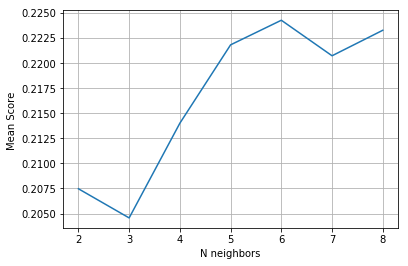

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n_neigh = list(range(2, 9))  
mean_score = [ 0.2074700109051254, 0.20456197746274085, 
              0.21401308615049072, 0.22182842602689934, 0.2242820792439113, 
              0.2207379134860051, 0.22328244274809161]
plt.plot(n_neigh, mean_score)
plt.ylabel('Mean Score ')
plt.xlabel('N neighbors')
plt.grid()


Наибольший score получается при использовании модели с 6 соседями 

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = TfidfTransformer()
data_tfidf = vectorizer.fit_transform(data_tok_vect).toarray()

print(data_tfidf.shape)

(11004, 33932)


In [39]:
data_tfidf.shape

(11004, 33932)

Kd_tree и TfIdf

In [0]:
kf= KFold(3, shuffle = True, random_state = 1)
scores = []
for train_ind, test_ind in kf.split(data_tfidf):
    clf = MyKNeighborsClassifier(n_neighbors = 6, algorithm='kd_tree')
    X_train, X_test = data_tfidf[train_ind], data_tfidf[test_ind]
    y_train, y_test = target[train_ind], target[test_ind]
    clf.fit(X_train, y_train)
    sc = clf.score(X_test, y_test)
    scores.append(sc)
score = np.mean(scores)
print (score) 

0.4940021810250818


Косинусная метрика и TfIdf

In [0]:
kf= KFold(3, shuffle = True, random_state = 1)
scores = []
for train_ind, test_ind in kf.split(data_tfidf):
    clf = MyKNeighborsClassifier(n_neighbors = 6, algorithm='brute', metric='cosine')X_train, X_test = data_tfidf[train_ind], data_tfidf[test_ind]
    y_train, y_test = target[train_ind], target[test_ind]
    clf.fit(X_train, y_train)
    sc = clf.score(X_test, y_test)
    scores.append(sc)
score = np.mean(scores)
print(score)    

0.6449472918938567


Лучшее качетсво достигается на алгоритме, использующем косинусную метрику, примененном к данным, к которым было применено TfIdf преобразование

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [40]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [41]:
data_test = newsgroups['data']
target_test = newsgroups['target']
data_test = list(map(lambda x: x.lower(), data_test))

reg = re.compile('[^a-z ]')
for i, text in enumerate(data_test):
    text = text.replace('\n', ' ').replace('\t', ' ')
    data_test[i] = reg.sub('', text)
data_test_tok = list(map(lambda x: list(x.split(' ')), data_test))     

In [42]:
inds = np.where(True == np.array(list(((map(lambda tok: all(map(lambda x: x=='', tok)), data_test_tok))))))
data_test_tok = np.delete(data_test_tok, inds)
target_test = np.delete(target_test, inds)

In [43]:
assert all(isinstance(row, (list, tuple)) for row in data_test_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_test_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_test_tok))), "please make sure that you lowercase the data and drop spaced texts"

In [44]:
lem_data_test_tok = [[lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)] for text in data_test]

In [45]:
from scipy.sparse import csr_matrix
data_test = []
indptr_test = [0]
indices_test = []
vocabulary_test = {}

for l in lem_data_test_tok:
    for term in l:
        index_test = vocabulary.setdefault(term, len(vocabulary_test))
        indices_test.append(index_test)
        data_test.append(1)
    indptr_test.append(len(indices_test))


data_test_tok_vect = csr_matrix((data_test, indices_test, indptr_test), dtype=int).toarray()

In [46]:
data_test_tok_vect = np.delete(data_test_tok_vect, inds, axis = 0)
data_test_tok_vect = np.delete(data_test_tok_vect, ind_to_del, axis = 1)
data_test_tok_vect.shape


(7307, 33932)

In [47]:
data_test_tfidf = vectorizer.fit_transform(data_test_tok_vect).toarray()

In [48]:
clf = MyKNeighborsClassifier(n_neighbors=6, algorithm='brute', metric='cosine')
X_train, X_test, y_train, y_test = train_test_split(data_tfidf, target,
                                                    test_size=0.3, random_state=1, stratify=target)
clf.fit(X_train, y_train)

In [34]:
print(clf.score(X_test, y_test))

0.6532404603270745


In [35]:
clf.score(data_test_tfidf, target_test)

0.5546736006569044

На тестовой части датасета качество ухудшилось. 